In [1]:
from pathlib import Path
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import datetime
import calendar
import numpy as np
import os
import glob
from openpyxl import load_workbook
%matplotlib inline

# 데이터 크기, 결측치 확인 관련함수

# 결측값 개수 확인
def CheckDF_IsNull(_df):
    print(_df.isnull().sum())

# DF 타입 확인
def CheckDF_Types(_df):
    print(_df.dtypes)
    
# DF shape확인
def CheckDF_shape(_df):
    print(_df.shape)

In [2]:
import requests
from bs4 import BeautifulSoup
from urllib import parse 

# API를 이용해 국경일,대체 공휴일 포함 공휴일 DF 추출

# _apiKey :
# _url :
# 가져올 정보 명
# _year : 국경일 찾을 년도
def getHoliday(_apiKey,_url,_operation,_year):
    api_key_decode = parse.unquote(_apiKey)

    url_holiday = _url + _operation
    params = {
        "ServiceKey":api_key_decode,
        "solYear":_year,
        "numOfRows": 100
    }
    
    Day_list= ['Mon','Tues','Wednes','Thurs','Fri','Satur','Sun']
    
    response = requests.get(url_holiday, params = params)
    xml = BeautifulSoup(response.text, "lxml")
    items = xml.find('items')
    item_list = []

    for item in items:
        dt = datetime.datetime.strptime(item.find("locdate").text.strip(), '%Y%m%d')
        item_dict = {
            "이름" : item.find("datename").text.strip(),
            "날짜" : dt,
            "요일" : Day_list[dt.weekday()]+'day'
        }
        item_list.append(item_dict)
    return pd.DataFrame(item_list)

# 국경일 평일 df 추출
def getHolidayWeekDay(_NationalHolidayDf):
    _HolidayWeekDayDf = _NationalHolidayDf[_NationalHolidayDf['날짜'].dt.dayofweek < 5]
    return _HolidayWeekDayDf

# 국경일 주말 df 추출
def getHolidayWeekEnd(_NationalHolidayDf):
    _HolidayWeekEndDf = _NationalHolidayDf[_NationalHolidayDf['날짜'].dt.dayofweek > 4]
    return _HolidayWeekEndDf

In [5]:
_apiKey = ""
url = "	http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/"
operation = "getRestDeInfo"

NationalHolidayDf2020 = getHoliday(_apiKey,url,operation,2020)
NationalHolidayDf2021 = getHoliday(_apiKey,url,operation,2021)
NationalHolidayDf2021

,이름,날짜,요일
0,1월1일,2021-01-01,Friday
1,설날,2021-02-11,Thursday
2,설날,2021-02-12,Friday
3,설날,2021-02-13,Saturday
4,삼일절,2021-03-01,Monday
5,어린이날,2021-05-05,Wednesday
6,부처님오신날,2021-05-19,Wednesday
7,현충일,2021-06-06,Sunday
8,광복절,2021-08-15,Sunday
9,대체공휴일,2021-08-16,Monday


In [434]:
# 데이터 전처리 메소드

# html 형식 파일 xlsx로 변환
def ChangeHtmlToXlsx(_year,_month,_folder,_kind):
    if(_kind==0):
        _folder = _folder+'교통량/'
    elif(_kind==1):
        _folder = _folder+'점유율/'
    else:
        _folder = _folder+'평균속도/'
    
    rawData_dir = Path(_folder)
    
    if(_kind == 0):
        excel_files = rawData_dir.glob('VDS_0'+str(_month)+'*_교통량.xls')
    elif(_kind == 1):
        excel_files = rawData_dir.glob('VDS_0'+str(_month)+'*_점유율.xls')
    else:
        excel_files = rawData_dir.glob('VDS_0'+str(_month)+'*_평균속도.xls')
    
    dayList = [1,2,3,6,7,8,9,10,13,14,15,16,17,20,21,22,23,24,27,28,29,30,31]
    
    _day = 0
    for excel_file in excel_files:
        _list = pd.read_html(excel_file)
        if(dayList[_day] < 10):
            _list[0].to_excel(_folder+str(_year)+'_0'+str(_month)+'_0'+str(dayList[_day])+'_점유율.xlsx',index=False)
        else:
            _list[0].to_excel(_folder+str(_year)+'_0'+str(_month)+'_'+str(dayList[_day])+'_점유율.xlsx',index=False)
        _day = _day + 1    

# folder 안의 vds 데이터 합치기
def ExcelAppend(_year,_month,_folder,_kind):
    if(_kind==0):
        _folder = _folder+'교통량/'
    elif(_kind==1):
        _folder = _folder+'점유율/'
    else:
        _folder = _folder+'평균속도/'
        
    rawData_dir = Path(_folder)
    
    if(_month < 10):
        if(_kind == 0):
            excel_files = rawData_dir.glob(str(_year)+'_0'+str(_month)+'_*_교통량.xlsx')
        elif(_kind == 1):
            excel_files = rawData_dir.glob(str(_year)+'_0'+str(_month)+'_*_점유율.xlsx')
        else:
            excel_files = rawData_dir.glob(str(_year)+'_0'+str(_month)+'_*_평균속도.xlsx')
    else:
        if(_kind == 0):
            excel_files = rawData_dir.glob(str(_year)+'_'+str(_month)+'_*_교통량.xlsx')
        elif(_kind == 1):
            excel_files = rawData_dir.glob(str(_year)+'_'+str(_month)+'_*_점유율.xlsx')
        else:
            excel_files = rawData_dir.glob(str(_year)+'_'+str(_month)+'_*_평균속도.xlsx')

    total_df = pd.DataFrame()

    for excel_file in excel_files:
        df = pd.read_excel(excel_file)
        total_df = total_df.append(df, ignore_index=True)
    return total_df

# 43105 형식의 숫자 -> 날짜 형식으로 변환 : df.map() 적용
def dateChange(_date):
    return (datetime.date(1899,12,30) + datetime.timedelta(int(_date))).strftime('%Y-%m-%d')

def NumberExtract(_str):
    _strList = re.findall("\d+",_str)
    _dateStr = _strList[0]+'-'+_strList[1]+'-'+_strList[2]
    return _dateStr

# 데이터프레임 전처리
# 결측값 행 제거
# 인덱스 재설정
# 날짜 변환
def PreprocessingTotalDf(_total_df) :
    _total_df = _total_df.dropna(axis=0) 
    _total_df = _total_df.reset_index(drop=True)
    if(len(str(_total_df.iloc[0].일자))==5):
        _total_df['일자'] = _total_df['일자'].map(dateChange)
    else:
        _idx = _total_df[_total_df['도로']=='평균값'].index
        _total_df = _total_df.drop(_idx, axis=0)
        _total_df['일자'] = _total_df['일자'].map(NumberExtract)
    _total_df['시간'] = _total_df['시간'].astype(str)
    _total_df['일자'] = _total_df['일자'] + ' ' + _total_df['시간']
    _df = _total_df[['일자','평균']]
    return _df

# 화, 수, 목 데이터 추출 (월,금 제외)
def getTuesBetweenThursDayDF(_df):
    _df['일자'] = pd.to_datetime(_df['일자'],format='%Y-%m-%d')
    _resultDf = _df[(_df['일자'].dt.dayofweek > 0) & (_df['일자'].dt.dayofweek < 4)]
    _resultDf = _resultDf.reset_index(drop=True)
    return _resultDf

In [435]:
ChangeHtmlToXlsx(2020,7,'./대전_한밭대로_봉명동/5분데이터_평일/',1)

In [436]:
# 한달 화,수,목 5분단위 교통량 데이터 추출
_totalDf = ExcelAppend(2020,7,'./대전_한밭대로_봉명동/5분데이터_평일/',1)
_totalDf = PreprocessingTotalDf(_totalDf)
_TrafficDf = getTuesBetweenThursDayDF(_totalDf)
_TrafficDf

,일자,평균
0,2020-07-01 00:00:00,1.84
1,2020-07-01 00:05:00,1.97
2,2020-07-01 00:10:00,3.65
3,2020-07-01 00:15:00,1.92
4,2020-07-01 00:20:00,1.57
...,...,...
4021,2020-07-30 23:35:00,6.64
4022,2020-07-30 23:40:00,3.87
4023,2020-07-30 23:45:00,3.27
4024,2020-07-30 23:50:00,2.71


In [422]:
def OpenExcel(_filePath):
    _df = pd.read_excel(_filePath)
    return _df 

# 기상날씨 데이터 결측값 확인
# df 개수 확인
def Check_DF_len(_folder,_year,_month):
    rawData_dir = Path(_folder)
    if(_month < 10):
        excel_files = rawData_dir.glob(str(_year)+'_0'+str(_month)+'_*.xlsx')
    else:
        excel_files = rawData_dir.glob(str(_year)+'_'+str(_month)+'_*.xlsx')

    total_df = pd.DataFrame()

    for excel_file in excel_files:
        df = pd.read_excel(excel_file)
        print(str(excel_file).split('\\')[-1]+' 개수 :'+str(len(df)))
    

def Column_Rename(_df):
    _df.rename(columns={
                      '일시':'일자',  
                      '기온(°C)':'기온',
                      '누적강수량(mm)':'누적강수량'}, inplace=True)
    return _df 

def Extraction_dayList_InTrafficData(_df):
    _df_set = set(_df['일자'].values)
    _df_list = list(_df_set)
    _list = sorted(_df_list)
    return _list

# 끝 행 자르고 , 첫 행 추가
# 5분 단위로 만들기
def Weather_PreprocessingDF(_df):
    _reNameDf = Column_Rename(_df)
    _reNameDf = _reNameDf.drop(len(_df)-1)
    new_data = {
        '지점':_reNameDf.iloc[0].지점,
        '지점명':_reNameDf.iloc[0].지점명,
        '일자':_reNameDf.iloc[0].일자 - datetime.timedelta(minutes=1),
        '기온':_reNameDf.iloc[0].기온,
        '누적강수량':_reNameDf.iloc[0].누적강수량
    }
    _reNameDf = _reNameDf.append(new_data, ignore_index=True)
    _reNameDf = _reNameDf.sort_values(by=['일자'],ascending=True)
    _reNameDf = _reNameDf.reset_index(drop=True)
    
    _resultDf = pd.DataFrame()
    
    for _index in _reNameDf.index:
        if(_index % 5 == 0):
            _resultDf = _resultDf.append(_reNameDf.iloc[_index], ignore_index=True)
    
    return _resultDf

# 강수량 컬럼 추가
# 누적강수량, 강수량 NaN 인것들 0으로 채워넣음
def Weather_AddColumnPrecipitation(_df):
    _list = []
    for _index in range(1,len(_df)):
        _list.append(round(_df.iloc[_index].누적강수량 - _df.iloc[_index-1].누적강수량,1))
    _list.append(_list[-1])  
    _df['강수량'] = _list
    _result = _df[['일자','누적강수량','강수량']]
    _result = _result.fillna(0)
    return _result

# 1분단위 기상데이터를 5분단위 엑셀로 저장 [일시,누적강수량,강수량] 
def SaveExcel_FiveMinutes_WeatherData(_folderPath):
    rawData_dir = Path(_folderPath)
    excel_files = rawData_dir.glob('2020_07_*.xlsx')
    for _file in excel_files:
        df = pd.read_excel(_file)
        df = Weather_PreprocessingDF(df)
        df = Weather_AddColumnPrecipitation(df)
        df.to_excel(_folderPath+'5분단위/'+str(_file).split('\\')[-1], index=False)
        
# 기상날씨 데이터 합치기
def Weather_ExcelAppend(_folder,_year,_month):
    rawData_dir = Path(_folder)
    if(_month < 10):
        excel_files = rawData_dir.glob(str(_year)+'_0'+str(_month)+'_*.xlsx')
    else:
        excel_files = rawData_dir.glob(str(_year)+'_'+str(_month)+'_*.xlsx')

    total_df = pd.DataFrame()

    for excel_file in excel_files:
        df = pd.read_excel(excel_file)
        total_df = total_df.append(df, ignore_index=True)
    return total_df

# 화, 수, 목 데이터 추출 (월,금 제외)
def Weather_getTuesBetweenThursDayDF(_df):
    _df['일자'] = pd.to_datetime(_df['일자'],format='%Y-%m-%d')
    _resultDf = _df[(_df['일자'].dt.dayofweek > 0) & (_df['일자'].dt.dayofweek < 4)]
    _resultDf = _resultDf.reset_index(drop=True)
    return _resultDf

# 맑은날 , 흐린날 합친 DF
def Merge_TrafficAndWeather(_trafficDf,_weatherDf):
    merge_outer = pd.merge(_trafficDf,_weatherDf,how='outer',on='일자')
    merge_outer = merge_outer.fillna(0)

    merge_outer['일자'] = merge_outer['일자'].astype(str)
    merge_outer['시간'] = merge_outer.일자.str.split(' ').str[1]
    merge_outer['일자'] = merge_outer.일자.str.split(' ').str[0]
    merge_outer['시간'] = merge_outer.시간.str.split(':').str[0] +':'+ merge_outer.시간.str.split(':').str[1]
    return merge_outer

# 시간대별 교통량 DF 추출 후 _SumOrStat : 0 = 15분 단위별 교통량 합계 DF 반환, 1 = 15분 단위별 교통량 평균 DF 반환
def Extraction_DF_Traffic_SumOrStat(_df,_SumOrStat):
    month_df = _df[['시간','평균']]
    if(_SumOrStat == 0):
        month_sum = month_df.groupby('시간').sum()
        return month_sum
    elif(_SumOrStat == 1):
        month_stat = month_df.groupby('시간').mean()
        month_stat['평균'] = round(month_stat['평균'],2)
        return month_stat
    else:
        exception = "_SumOrStat : 0 -> Sum , 1 -> Stat"
        return exception

In [258]:
Check_DF_len('./대전_한밭대로_봉명동/기상정보/1분단위2020_07기상정보(강수량1이상인평일)/',2020,7)

2020_07_01.xlsx 개수 :1440
2020_07_03.xlsx 개수 :1440
2020_07_06.xlsx 개수 :1440
2020_07_07.xlsx 개수 :1440
2020_07_10.xlsx 개수 :1440
2020_07_13.xlsx 개수 :1440
2020_07_14.xlsx 개수 :1440
2020_07_15.xlsx 개수 :1440
2020_07_20.xlsx 개수 :1440
2020_07_22.xlsx 개수 :1440
2020_07_23.xlsx 개수 :1440
2020_07_24.xlsx 개수 :1440
2020_07_27.xlsx 개수 :1440
2020_07_28.xlsx 개수 :1440
2020_07_29.xlsx 개수 :1440
2020_07_30.xlsx 개수 :1440
2020_07_31.xlsx 개수 :1440


In [260]:
#SaveExcel_FiveMinutes_WeatherData('./대전_한밭대로_봉명동/기상정보/1분단위2020_07기상정보(강수량1이상인평일)/')

In [261]:
# 7월 비온날 합친 DF
weatherDf = Weather_ExcelAppend('./대전_한밭대로_봉명동/기상정보/1분단위2020_07기상정보(강수량1이상인평일)/5분단위/',2020,7)
weatherDf = Weather_getTuesBetweenThursDayDF(weatherDf)
weatherDf

,일자,누적강수량,강수량
0,2020-07-01 00:00:00,0.0,0.0
1,2020-07-01 00:05:00,0.0,0.0
2,2020-07-01 00:10:00,0.0,0.0
3,2020-07-01 00:15:00,0.0,0.0
4,2020-07-01 00:20:00,0.0,0.1
...,...,...,...
2587,2020-07-30 23:35:00,141.3,0.0
2588,2020-07-30 23:40:00,141.3,0.0
2589,2020-07-30 23:45:00,141.3,0.0
2590,2020-07-30 23:50:00,141.3,0.0


In [262]:
_TrafficDf

,일자,평균
0,2020-07-01 00:00:00,79
1,2020-07-01 00:05:00,70
2,2020-07-01 00:10:00,67
3,2020-07-01 00:15:00,63
4,2020-07-01 00:20:00,59
...,...,...
4021,2020-07-30 23:35:00,83
4022,2020-07-30 23:40:00,86
4023,2020-07-30 23:45:00,90
4024,2020-07-30 23:50:00,79


In [294]:
# 흐린날, 맑은날 합친 df 
mergeDF = Merge_TrafficAndWeather(_TrafficDf,weatherDf)

In [295]:
# 비온날 추출
cloudyDF = mergeDF[mergeDF['강수량']>0]
cloudyDF

,일자,평균,누적강수량,강수량,시간
4,2020-07-01,59,0.0,0.1,00:20
7,2020-07-01,49,0.1,0.1,00:35
584,2020-07-07,61,0.0,0.1,00:40
585,2020-07-07,41,0.1,0.1,00:45
1442,2020-07-14,53,0.0,0.1,00:40
...,...,...,...,...,...
3852,2020-07-30,242,140.8,0.1,09:30
3854,2020-07-30,263,140.9,0.1,09:40
3862,2020-07-30,200,141.0,0.1,10:20
3863,2020-07-30,199,141.1,0.1,10:25


In [335]:
Extraction_dayList_InTrafficData(cloudyDF)

['2020-07-01',
 '2020-07-07',
 '2020-07-14',
 '2020-07-15',
 '2020-07-22',
 '2020-07-23',
 '2020-07-28',
 '2020-07-29',
 '2020-07-30']

In [332]:
CheckDF_Types(cloudyDF)

일자        object
평균         int64
누적강수량    float64
강수량      float64
시간        object
dtype: object


In [300]:
# 맑은날 추출
cleanDF = mergeDF[mergeDF['강수량']==0]
cleanDF = Extraction_DF_Traffic_SumOrStat(cleanDF,1)
cleanDF

,평균
시간,
00:00,75.38
00:05,62.69
00:10,64.46
00:15,71.29
00:20,58.25
...,...
23:35,82.31
23:40,83.14
23:45,89.93


In [297]:
#강수량 차이가 많이 나는 것부터 순서대로 
cloudyDF.sort_values(by=['강수량'],ascending=False)

,일자,평균,누적강수량,강수량,시간
3790,2020-07-30,22,49.8,5.9,04:20
3830,2020-07-30,331,97.3,5.8,07:40
3834,2020-07-30,293,112.9,5.7,08:00
3562,2020-07-29,211,48.8,5.5,09:20
3788,2020-07-30,29,39.2,5.3,04:10
...,...,...,...,...,...
2682,2020-07-22,284,15.1,0.1,08:00
2680,2020-07-22,268,14.8,0.1,07:50
2679,2020-07-22,243,14.7,0.1,07:45
2678,2020-07-22,331,14.6,0.1,07:40


In [420]:
_totalDf = ExcelAppend(2020,7,'./대전_한밭대로_봉명동/5분데이터_평일/',3)
_totalDf

,일자,요일,도로,VDS ID,방향,시간,평균
0,2020년 07월 01일,수요일,한밭대로,VDS0023,상행,00:00,58.4
1,2020년 07월 01일,수요일,한밭대로,VDS0023,상행,00:05,58.3
2,2020년 07월 01일,수요일,한밭대로,VDS0023,상행,00:10,58.7
3,2020년 07월 01일,수요일,한밭대로,VDS0023,상행,00:15,61.6
4,2020년 07월 01일,수요일,한밭대로,VDS0023,상행,00:20,59.2
...,...,...,...,...,...,...,...
6659,2020년 07월 31일,금요일,한밭대로,VDS0023,상행,23:45,58.6
6660,2020년 07월 31일,금요일,한밭대로,VDS0023,상행,23:50,59.6
6661,2020년 07월 31일,금요일,한밭대로,VDS0023,상행,23:55,53.1
6662,2020년 07월 31일,금요일,평균값,평균값,평균값,평균값,52.2


In [437]:
import itertools
# 그래프 그리기

# 맑은날 평균 , 비오는 날 산점도
# 화, 수, 목  
def DrawMonthly_Compare_CleanAndCloudyDay(_year,_month,_kind):
    _weatherDf = Weather_ExcelAppend('./대전_한밭대로_봉명동/기상정보/1분단위2020_07기상정보(강수량1이상인평일)/5분단위/',_year,_month)
    _weatherDf = Weather_getTuesBetweenThursDayDF(_weatherDf)
    
    _totalDf = ExcelAppend(_year,_month,'./대전_한밭대로_봉명동/5분데이터_평일/',_kind)
    _totalDf = PreprocessingTotalDf(_totalDf)
    _trafficDf = getTuesBetweenThursDayDF(_totalDf)
    
    mergeDF = Merge_TrafficAndWeather(_trafficDf,_weatherDf)
    
    cloudyDF = mergeDF[mergeDF['강수량']>0]
    cleanDF = mergeDF[mergeDF['강수량']==0]
    cleanDF = Extraction_DF_Traffic_SumOrStat(cleanDF,1)
    
    fig = plt.figure(figsize=(50,6))
    ax = fig.add_subplot()
    ax.plot(cleanDF['평균'],label='cleanDay 7month')
   
    
    cloudyDay_List = Extraction_dayList_InTrafficData(cloudyDF)
    
    colorIndex = 0
    
    for _cloudyDay in cloudyDay_List:
        cloudy_df = cloudyDF[cloudyDF['일자'] == _cloudyDay]
        cloudy_df = cloudy_df.reset_index(drop=True)
        
        if not cloudy_df.empty:
            stepOne = cloudy_df[(cloudy_df['강수량']>=0.1) & (cloudy_df['강수량']<3)]
            stepTwe = cloudy_df[(cloudy_df['강수량']>=3) & (cloudy_df['강수량']<5)]
            stepThree = cloudy_df[(cloudy_df['강수량']>=5)]
            
#            color=['r','g','b','k','c','m','y','o','p']
            #color=itertools.cycle(["black","orange","pink","blue","brown","red","grey","yellow","green"])
            color= ["black","orange","pink","blue","brown","red","grey","yellow","green"]
            if not stepOne.empty:
                ax.scatter(stepOne['시간'],
                           stepOne['평균'],
                           alpha=1,
                           s=30,
                           c=color[colorIndex],
                           label = _cloudyDay)
            if not stepTwe.empty:
                ax.scatter(stepTwe['시간'],
                           stepTwe['평균'],
                           alpha=1,
                           s=70,
                           c=color[colorIndex],
                           marker = '^',
                           label = _cloudyDay)
            if not stepThree.empty:
                ax.scatter(stepThree['시간'],
                           stepThree['평균'],
                           alpha=1,
                           s=100,
                           c=color[colorIndex],
                           #c=next(color),
                           marker = '*',
                           label = _cloudyDay)
            
            colorIndex = colorIndex+1 
            
    ax.legend()
    plt.xticks(rotation=45)
    plt.title('Compare CleanDay vs CloudyDay Average')
    plt.xlabel('time')
    plt.grid(True)
    #plt.show()
    if(_kind == 0):
        plt.ylabel('traffic vloume')
        plt.savefig('./대전_한밭대로_봉명동/사진/'+str(_month)+'월_맑은날흐린날산점도_교통량.png')
    elif(_kind == 1):
        plt.ylabel('Share')
        plt.savefig('./대전_한밭대로_봉명동/사진/'+str(_month)+'월_맑은날흐린날산점도_점유율.png')
    else:
        plt.ylabel('Speed')
        plt.savefig('./대전_한밭대로_봉명동/사진/'+str(_month)+'월_맑은날흐린날산점도_평균속도.png')
    
# 맑은날 평균, 비오는 날 평균
# 화, 수, 목
def DrawMonthly_Compare_CleanAndCloudyDayAverage(_year,_month,_kind):
    _weatherDf = Weather_ExcelAppend('./대전_한밭대로_봉명동/기상정보/1분단위2020_07기상정보(강수량1이상인평일)/5분단위/',_year,_month)
    _weatherDf = Weather_getTuesBetweenThursDayDF(_weatherDf)
    
    _totalDf = ExcelAppend(_year,_month,'./대전_한밭대로_봉명동/5분데이터_평일/',_kind)
    _totalDf = PreprocessingTotalDf(_totalDf)
    _trafficDf = getTuesBetweenThursDayDF(_totalDf)
    
    mergeDF = Merge_TrafficAndWeather(_trafficDf,_weatherDf)
    
    cloudyDF = mergeDF[mergeDF['강수량']>0]
    cloudyDF = Extraction_DF_Traffic_SumOrStat(cloudyDF,1)
    
    cleanDF = mergeDF[mergeDF['강수량']==0]
    cleanDF = Extraction_DF_Traffic_SumOrStat(cleanDF,1)
    
    
    fig = plt.figure(figsize=(50,6))
    ax = fig.add_subplot()
    ax.plot(cleanDF['평균'],label='cleanDay 7month')
    ax.plot(cloudyDF['평균'],label='cloudyDay 7month')
    
    ax.legend()
    plt.xticks(rotation=90)
    plt.title('Compare CleanDay vs CloudyDay Average')
    plt.xlabel('time')
    plt.ylabel('traffic vloume')
    plt.grid(True)
    #plt.show()
    if(_kind == 0):
        plt.ylabel('traffic vloume')
        plt.savefig('./대전_한밭대로_봉명동/사진/'+str(_month)+'월_맑은날흐린날평균_교통량.png')
    elif(_kind == 1):
        plt.ylabel('Share')
        plt.savefig('./대전_한밭대로_봉명동/사진/'+str(_month)+'월_맑은날흐린날평균_점유율.png')
    else:
        plt.ylabel('Speed')
        plt.savefig('./대전_한밭대로_봉명동/사진/'+str(_month)+'월_맑은날흐린날평균_평균속도.png')


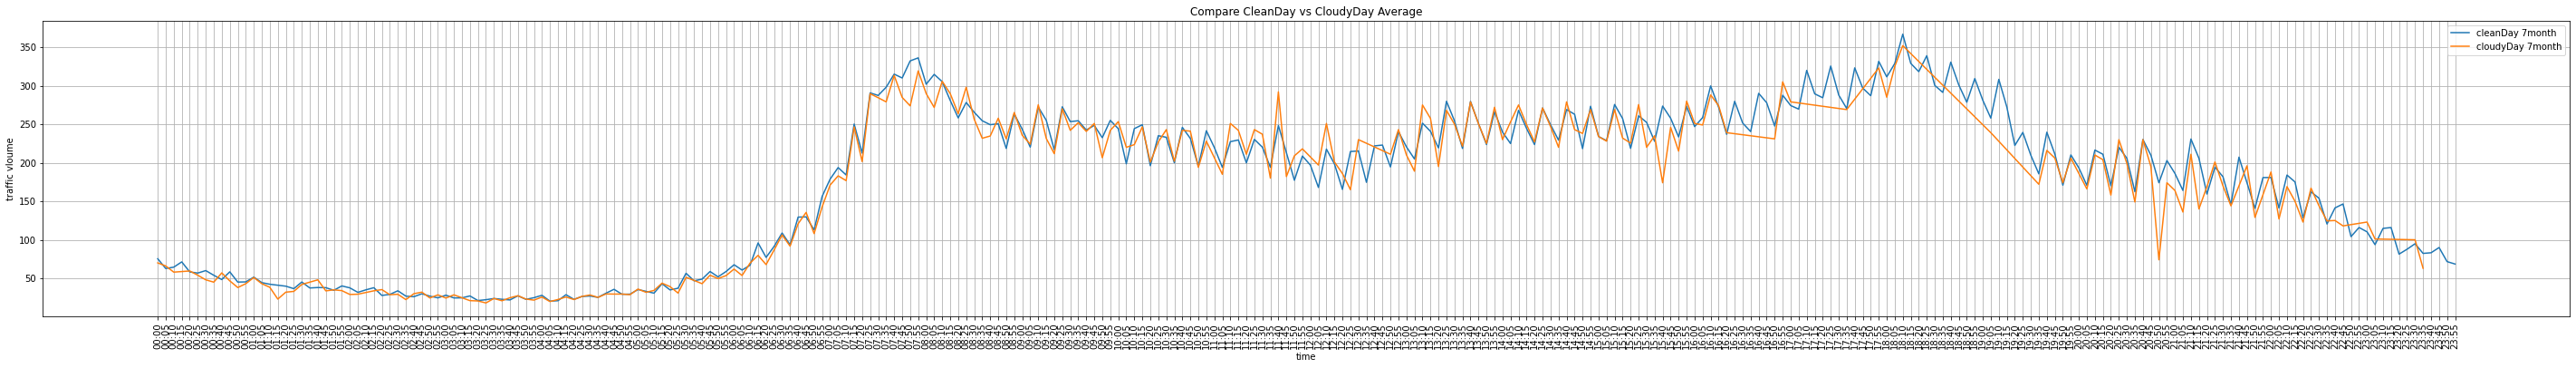

In [438]:
DrawMonthly_Compare_CleanAndCloudyDayAverage(2020,7,0)

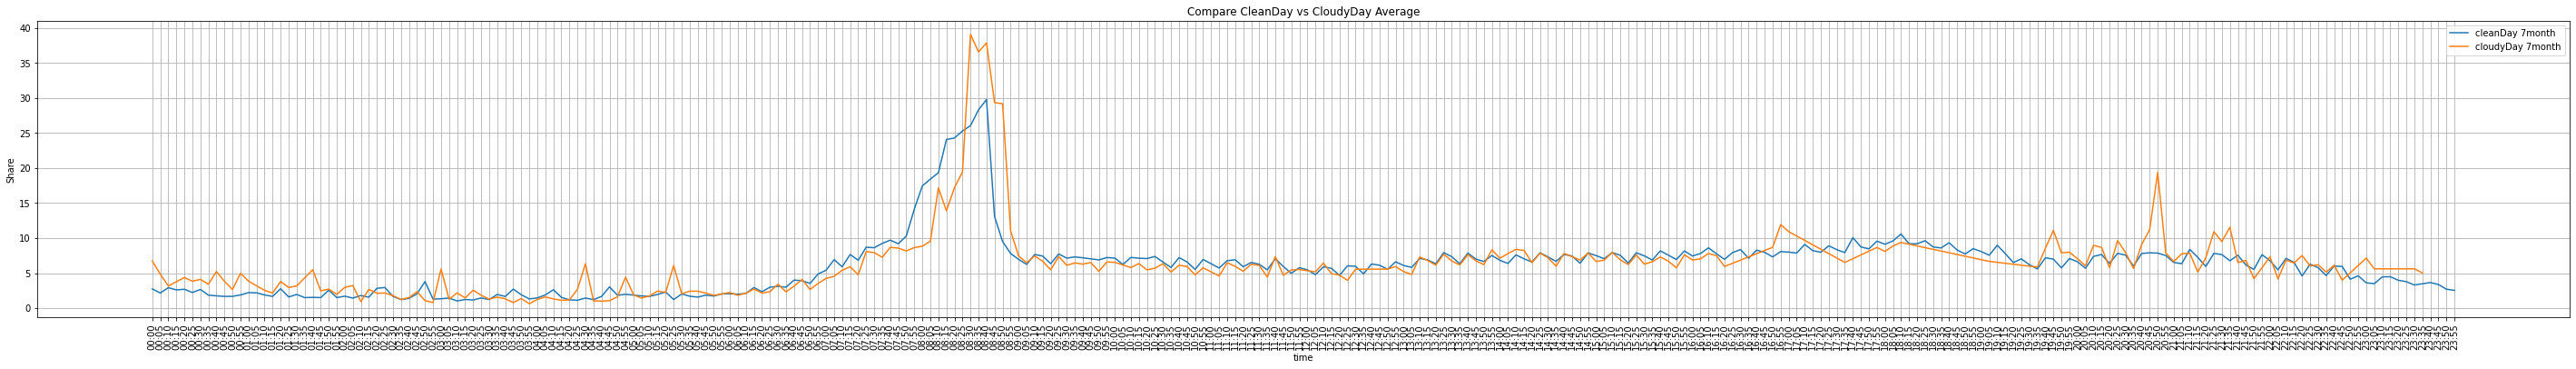

In [439]:
DrawMonthly_Compare_CleanAndCloudyDayAverage(2020,7,1)

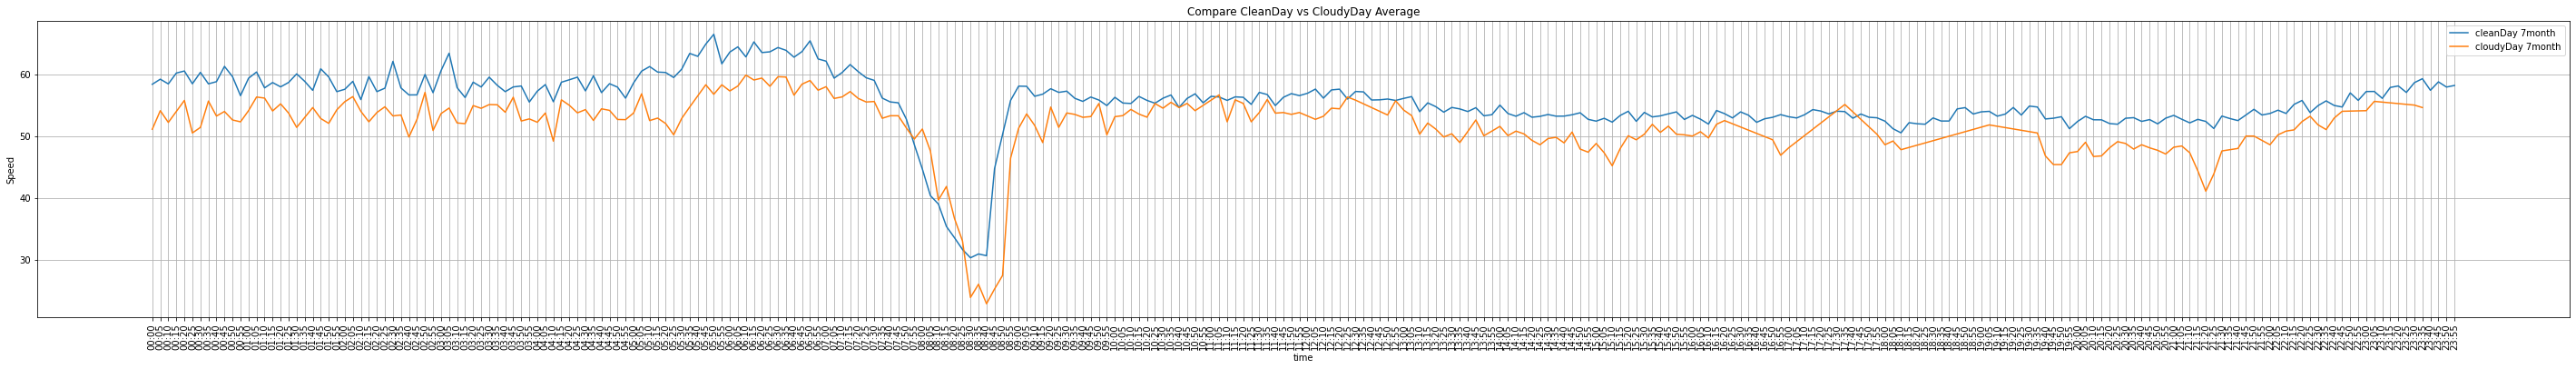

In [440]:
DrawMonthly_Compare_CleanAndCloudyDayAverage(2020,7,2)

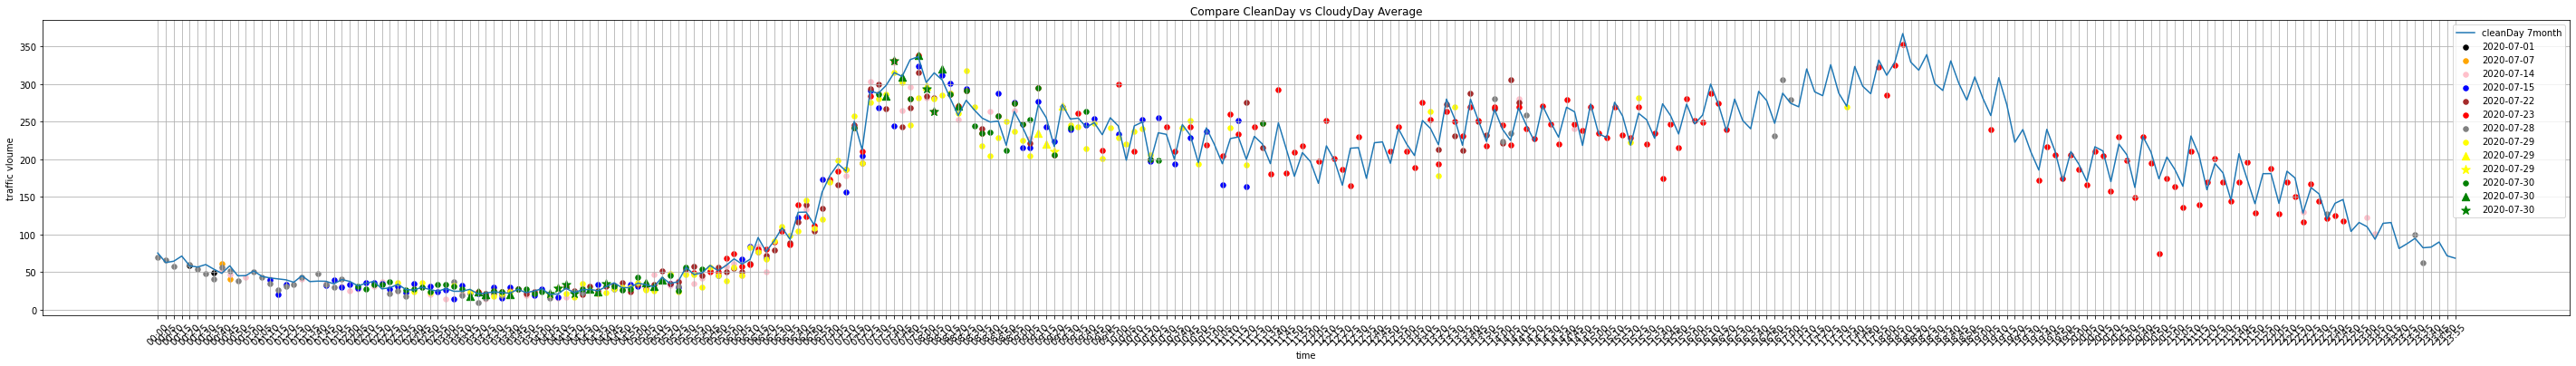

In [441]:
DrawMonthly_Compare_CleanAndCloudyDay(2020,7,0)

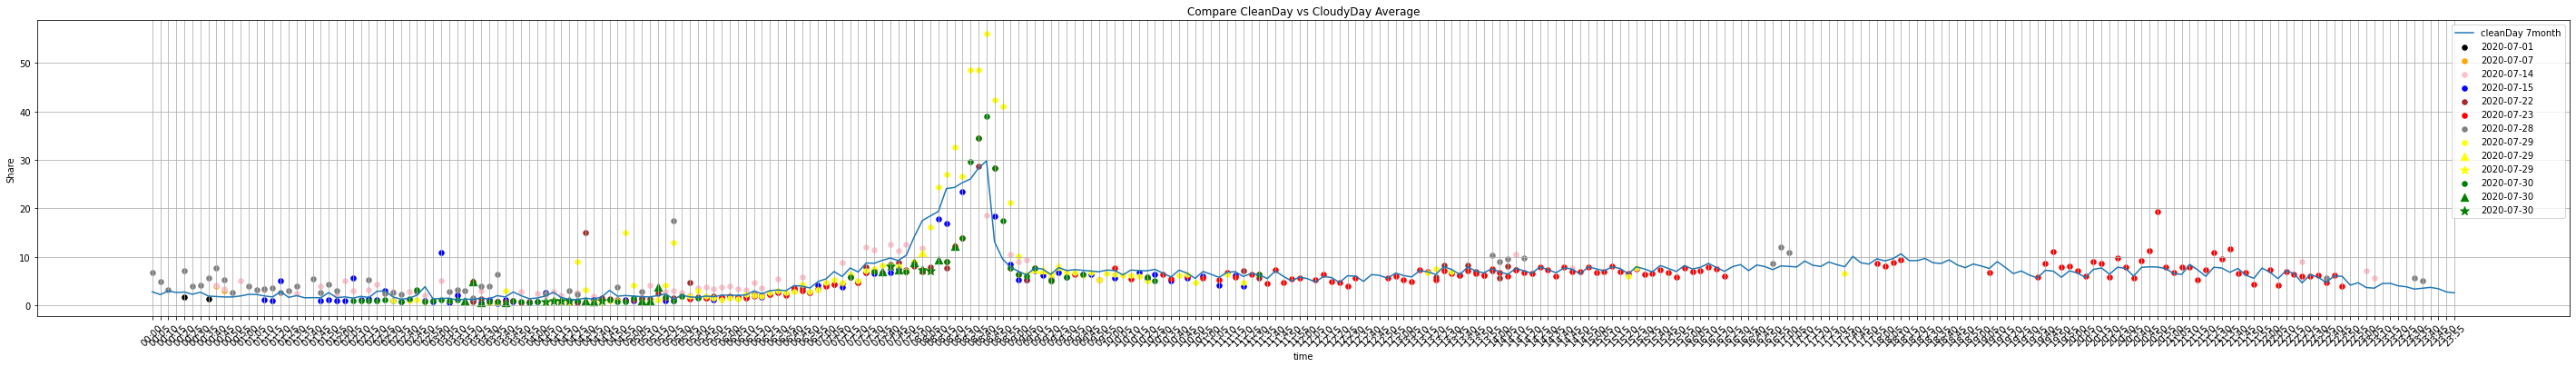

In [442]:
DrawMonthly_Compare_CleanAndCloudyDay(2020,7,1)

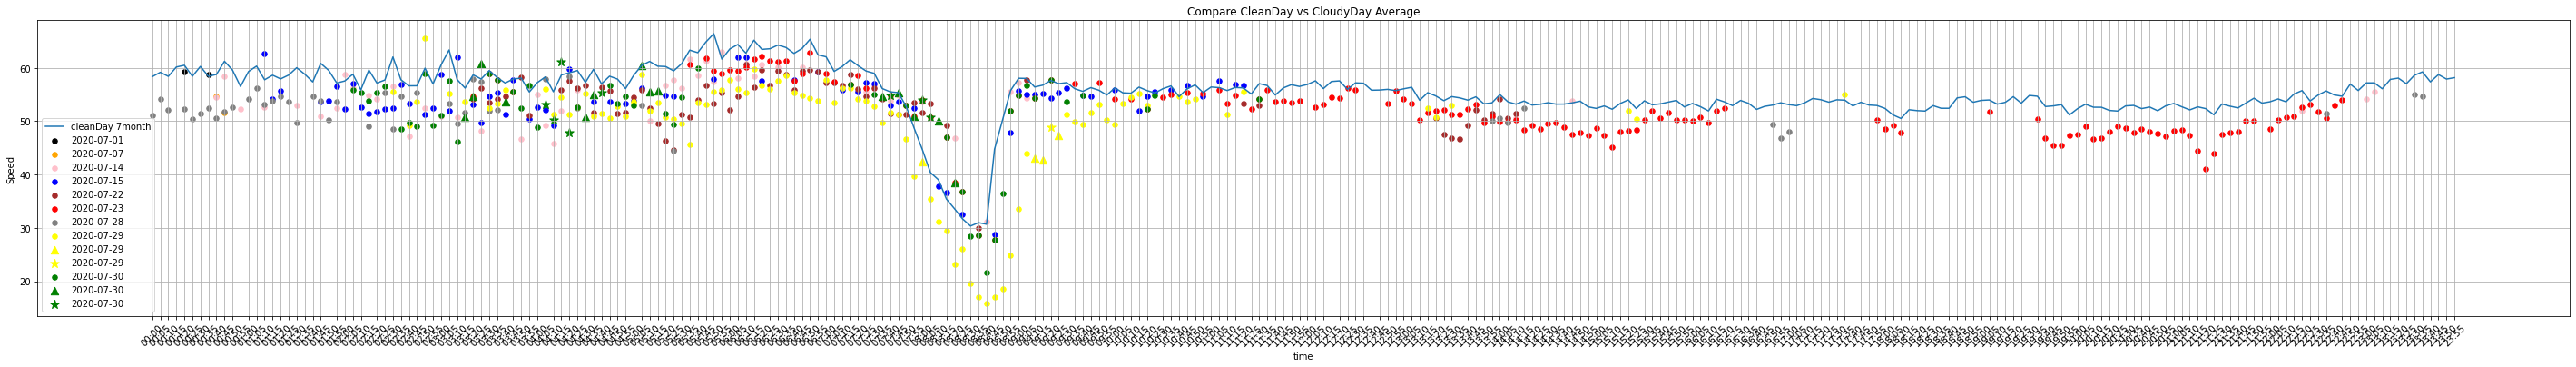

In [444]:
DrawMonthly_Compare_CleanAndCloudyDay(2020,7,2)